# NBA Game Prediction - Data Wrangling

This notebook prepares the data for modeling NBA game outcomes. We'll:
1. Load game data from `team_traditional.csv`
2. Calculate rolling features (last 10 games) - **no data leakage**
3. Create matchup dataset (home vs away)
4. Save processed data for modeling

**Key principle**: Only use data available BEFORE each game (point-in-time features)

## 1. Setup and Load Data


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

print("Packages loaded successfully!")


Packages loaded successfully!


In [52]:
# Load game data
games = pd.read_csv('team_traditional.csv')

# Convert date to datetime and sort by team and date
games['date'] = pd.to_datetime(games['date'])
games = games.sort_values(['team', 'date']).reset_index(drop=True)

print(f"Loaded {len(games):,} games")
print(f"Date range: {games['date'].min().date()} to {games['date'].max().date()}")
print(f"Teams: {games['team'].nunique()}")
print(f"Seasons: {games['season'].nunique()}")


Loaded 70,850 games
Date range: 1996-11-01 to 2025-06-22
Teams: 36
Seasons: 28


In [53]:
# Preview the data
print("Sample of raw data:")
games.head(10)


Sample of raw data:


,gameid,date,type,teamid,team,home,away,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,+/-,win,season
0,29600005,1996-11-01,regular,1610612737,ATL,MIA,ATL,48.0,81.0,25.0,65.0,38.5,4.0,16.0,25.0,27.0,32.0,84.4,10.0,30.0,40.0,13.0,24.0,10.0,7.0,20.0,-13.0,0.0,1997
1,29600017,1996-11-02,regular,1610612737,ATL,ATL,DET,48.0,78.0,29.0,72.0,40.3,8.0,24.0,33.3,12.0,17.0,70.6,12.0,29.0,41.0,11.0,19.0,3.0,3.0,20.0,-12.0,0.0,1997
2,29600030,1996-11-04,regular,1610612737,ATL,POR,ATL,48.0,94.0,32.0,74.0,43.2,11.0,17.0,64.7,19.0,23.0,82.6,10.0,24.0,34.0,15.0,16.0,10.0,8.0,20.0,18.0,1.0,1997
3,29600040,1996-11-05,regular,1610612737,ATL,SEA,ATL,48.0,117.0,43.0,82.0,52.4,16.0,29.0,55.2,15.0,18.0,83.3,10.0,28.0,38.0,23.0,15.0,9.0,3.0,20.0,22.0,1.0,1997
4,29600051,1996-11-07,regular,1610612737,ATL,SAC,ATL,48.0,91.0,32.0,74.0,43.2,4.0,18.0,22.2,23.0,37.0,62.2,15.0,30.0,45.0,15.0,17.0,8.0,5.0,17.0,4.0,1.0,1997
5,29600072,1996-11-10,regular,1610612737,ATL,LAL,ATL,48.0,85.0,30.0,84.0,35.7,10.0,30.0,33.3,15.0,19.0,78.9,10.0,24.0,34.0,21.0,10.0,10.0,4.0,18.0,-7.0,0.0,1997
6,29600082,1996-11-12,regular,1610612737,ATL,ATL,CLE,48.0,87.0,32.0,76.0,42.1,7.0,22.0,31.8,16.0,19.0,84.2,12.0,22.0,34.0,22.0,14.0,5.0,5.0,22.0,4.0,1.0,1997
7,29600089,1996-11-13,regular,1610612737,ATL,BOS,ATL,48.0,85.0,31.0,76.0,40.8,11.0,27.0,40.7,12.0,22.0,54.5,14.0,27.0,41.0,24.0,27.0,10.0,5.0,18.0,-18.0,0.0,1997
8,29600108,1996-11-15,regular,1610612737,ATL,ATL,MIA,48.0,85.0,22.0,60.0,36.7,4.0,15.0,26.7,37.0,48.0,77.1,16.0,35.0,51.0,10.0,17.0,10.0,8.0,18.0,8.0,1.0,1997
9,29600120,1996-11-16,regular,1610612737,ATL,CHI,ATL,48.0,69.0,26.0,80.0,32.5,3.0,13.0,23.1,14.0,21.0,66.7,15.0,25.0,40.0,9.0,13.0,6.0,3.0,17.0,-28.0,0.0,1997


In [54]:
# Check for missing values
print("Missing values per column:")
print(games.isnull().sum()[games.isnull().sum() > 0])


Missing values per column:
Series([], dtype: int64)


In [55]:
# Calculate opponent points (each game has 2 rows, need to match opponents)
print("Calculating opponent points...")

# For each game, get the opponent's score
# Games have 2 rows per gameid - match them to find opponent's PTS
opp_pts = games.groupby('gameid')['PTS'].transform(lambda x: x.iloc[::-1].values)
games['opp_pts'] = opp_pts

print(f"✓ Opponent points calculated")
print(f"Sample check - first game:")
print(games[['team', 'PTS', 'opp_pts', '+/-']].head(2))


Calculating opponent points...
✓ Opponent points calculated
Sample check - first game:
  team   PTS  opp_pts   +/-
0  ATL  81.0     94.0 -13.0
1  ATL  78.0     90.0 -12.0


## 2. Calculate Rolling Features (Last 10 Games)

**Critical**: We use `.shift(1)` to ensure we only use games BEFORE the current one.  
This prevents data leakage - we can't use today's game stats to predict today's game!

**Features we're calculating:**
- **Tier 1**: pts, fg%, 3p%, opp_pts, win_pct, plus_minus, rest_days, is_b2b
- **Tier 2**: efg%, ts%, 3pa_rate, ast, tov, reb, stl, blk, pts_std, win_streak


In [56]:
# Helper function to calculate rolling averages (reduces repetition)
def rolling_avg(df, column, window=10, stat='mean'):
    """Calculate rolling average for a column, excluding current game"""
    grouped = df.groupby('team')[column].rolling(window, min_periods=1 if stat == 'mean' else 2)
    
    if stat == 'mean':
        result = grouped.mean()
    elif stat == 'std':
        result = grouped.std()
    
    return result.reset_index(level=0, drop=True).shift(1)

# Calculate rolling features
window = 10
print(f"Calculating rolling features (last {window} games)...")

# TIER 1: Core offensive stats
games['pts_L10'] = rolling_avg(games, 'PTS', window)
games['fg_pct_L10'] = rolling_avg(games, 'FG%', window)
games['3p_pct_L10'] = rolling_avg(games, '3P%', window)

# TIER 1: Defensive stats
games['opp_pts_L10'] = rolling_avg(games, 'opp_pts', window)

# TIER 1: Form/momentum
games['win_pct_L10'] = rolling_avg(games, 'win', window)
games['plus_minus_L10'] = rolling_avg(games, '+/-', window)

# TIER 2: Advanced shooting (calculate derived stats first)
games['eFG%'] = (games['FGM'] + 0.5 * games['3PM']) / games['FGA']
games['TS%'] = games['PTS'] / (2 * (games['FGA'] + 0.44 * games['FTA']))
games['3PA_rate'] = games['3PA'] / games['FGA']

games['efg_pct_L10'] = rolling_avg(games, 'eFG%', window)
games['ts_pct_L10'] = rolling_avg(games, 'TS%', window)
games['3pa_rate_L10'] = rolling_avg(games, '3PA_rate', window)

# TIER 2: Playmaking
games['ast_L10'] = rolling_avg(games, 'AST', window)
games['tov_L10'] = rolling_avg(games, 'TOV', window)

# TIER 2: Rebounding
games['reb_L10'] = rolling_avg(games, 'REB', window)

# TIER 2: Defense details
games['stl_L10'] = rolling_avg(games, 'STL', window)
games['blk_L10'] = rolling_avg(games, 'BLK', window)

# TIER 2: Consistency (point volatility - use std instead of mean)
games['pts_std_L10'] = rolling_avg(games, 'PTS', window, stat='std')

print("✓ Rolling features calculated (Tier 1 + Tier 2)")


Calculating rolling features (last 10 games)...
✓ Rolling features calculated (Tier 1 + Tier 2)


In [57]:
# Calculate contextual features
print("Calculating contextual features...")

# TIER 1: Rest days since last game
games['rest_days'] = games.groupby('team')['date'].diff().dt.days
games['rest_days'] = games['rest_days'].fillna(3)  # First game of season = 3 days rest

# TIER 1: Back-to-back indicator (1 if playing on consecutive days)
games['is_b2b'] = (games['rest_days'] <= 1).astype(int)

# Game number in season
games['game_num'] = games.groupby(['team', 'season']).cumcount() + 1

# TIER 2: Win streak (positive for wins, negative for losses)
def calculate_win_streak(series):
    """Calculate current win/loss streak"""
    streaks = []
    for i in range(len(series)):
        if i == 0:
            streaks.append(0)
        else:
            recent_wins = series[:i]  # Only past games
            if len(recent_wins) == 0:
                streaks.append(0)
            else:
                current = recent_wins.iloc[-1]
                streak = 0
                for j in range(len(recent_wins)-1, -1, -1):
                    if recent_wins.iloc[j] == current:
                        streak += 1
                    else:
                        break
                streaks.append(streak if current == 1 else -streak)
    return streaks

games['win_streak'] = games.groupby('team')['win'].transform(calculate_win_streak)

print("✓ Contextual features calculated (including win streaks)")


Calculating contextual features...
✓ Contextual features calculated (including win streaks)


In [58]:
# Check the features we created
print("Sample of features for one team:")
sample_team = games[games['team'] == games['team'].iloc[0]].head(15)
cols_to_show = ['date', 'team', 'PTS', 'pts_L10', 'win', 'win_pct_L10', 'rest_days', 'is_b2b']
sample_team[cols_to_show]


Sample of features for one team:


,date,team,PTS,pts_L10,win,win_pct_L10,rest_days,is_b2b
0,1996-11-01,ATL,81.0,NaN,0.0,NaN,3.0,0
1,1996-11-02,ATL,78.0,81.000000,0.0,0.000000,1.0,1
2,1996-11-04,ATL,94.0,79.500000,1.0,0.000000,2.0,0
3,1996-11-05,ATL,117.0,84.333333,1.0,0.333333,1.0,1
4,1996-11-07,ATL,91.0,92.500000,1.0,0.500000,2.0,0
5,1996-11-10,ATL,85.0,92.200000,0.0,0.600000,3.0,0
6,1996-11-12,ATL,87.0,91.000000,1.0,0.500000,2.0,0
7,1996-11-13,ATL,85.0,90.428571,0.0,0.571429,1.0,1
8,1996-11-15,ATL,85.0,89.750000,1.0,0.500000,2.0,0
9,1996-11-16,ATL,69.0,89.222222,0.0,0.555556,1.0,1


## 3. Create Matchup Dataset

Now we combine home and away team features for each game.  
Each row = 1 matchup with features for both teams.


In [59]:
# Split into home and away games
print("Creating matchup dataset...")

# Home team data (where team == home column)
home = games[games['team'] == games['home']].copy()
home.columns = [f'{col}_home' if col not in ['gameid', 'date', 'season'] else col 
                for col in home.columns]

# Away team data (where team == away column)
away = games[games['team'] == games['away']].copy()
away.columns = [f'{col}_away' if col not in ['gameid', 'date', 'season'] else col
                for col in away.columns]

print(f"Home games: {len(home):,}")
print(f"Away games: {len(away):,}")


Creating matchup dataset...
Home games: 35,420
Away games: 35,430


In [60]:
# Merge home and away on game ID
matchups = home.merge(away, on=['gameid', 'date', 'season'], how='inner')

print(f"✓ Created {len(matchups):,} matchups")
print(f"Columns: {len(matchups.columns)}")


✓ Created 35,420 matchups
Columns: 101


## 4. Calculate Matchup Differentials

For each feature, calculate: `home_value - away_value`  
These differentials are often more predictive than raw values.


In [61]:
# Calculate differentials for key features
print("Calculating matchup differentials...")

# TIER 1: Core offensive differentials
matchups['pts_L10_diff'] = matchups['pts_L10_home'] - matchups['pts_L10_away']
matchups['fg_pct_L10_diff'] = matchups['fg_pct_L10_home'] - matchups['fg_pct_L10_away']
matchups['3p_pct_L10_diff'] = matchups['3p_pct_L10_home'] - matchups['3p_pct_L10_away']

# TIER 1: Defensive differential
matchups['opp_pts_L10_diff'] = matchups['opp_pts_L10_home'] - matchups['opp_pts_L10_away']

# TIER 1: Form differentials
matchups['win_pct_L10_diff'] = matchups['win_pct_L10_home'] - matchups['win_pct_L10_away']
matchups['plus_minus_L10_diff'] = matchups['plus_minus_L10_home'] - matchups['plus_minus_L10_away']

# TIER 1: Rest advantage
matchups['rest_advantage'] = matchups['rest_days_home'] - matchups['rest_days_away']

# TIER 2: Advanced shooting differentials
matchups['efg_pct_L10_diff'] = matchups['efg_pct_L10_home'] - matchups['efg_pct_L10_away']
matchups['ts_pct_L10_diff'] = matchups['ts_pct_L10_home'] - matchups['ts_pct_L10_away']
matchups['3pa_rate_L10_diff'] = matchups['3pa_rate_L10_home'] - matchups['3pa_rate_L10_away']

# TIER 2: Playmaking differentials
matchups['ast_L10_diff'] = matchups['ast_L10_home'] - matchups['ast_L10_away']
matchups['tov_L10_diff'] = matchups['tov_L10_home'] - matchups['tov_L10_away']

# TIER 2: Rebounding differential
matchups['reb_L10_diff'] = matchups['reb_L10_home'] - matchups['reb_L10_away']

# TIER 2: Defense differentials
matchups['stl_L10_diff'] = matchups['stl_L10_home'] - matchups['stl_L10_away']
matchups['blk_L10_diff'] = matchups['blk_L10_home'] - matchups['blk_L10_away']

# TIER 2: Consistency & momentum differentials
matchups['pts_std_L10_diff'] = matchups['pts_std_L10_home'] - matchups['pts_std_L10_away']
matchups['win_streak_diff'] = matchups['win_streak_home'] - matchups['win_streak_away']

print("✓ Differentials calculated (Tier 1 + Tier 2)")


Calculating matchup differentials...
✓ Differentials calculated (Tier 1 + Tier 2)


In [62]:
# Preview matchup features
print("Sample matchup with features:")
sample_cols = ['date', 'team_home', 'team_away', 'win_home', 
               'pts_L10_diff', 'win_pct_L10_diff', 'rest_advantage', 
               'is_b2b_home', 'is_b2b_away']
matchups[sample_cols].head(10)


Sample matchup with features:


,date,team_home,team_away,win_home,pts_L10_diff,win_pct_L10_diff,rest_advantage,is_b2b_home,is_b2b_away
0,1996-11-02,ATL,DET,0.0,-14.000000,-1.000000,0.0,1,1
1,1996-11-12,ATL,CLE,1.0,2.000000,-0.300000,0.0,0,0
2,1996-11-15,ATL,MIA,1.0,-4.392857,-0.214286,0.0,0,0
3,1996-11-26,ATL,VAN,1.0,-1.200000,0.400000,1.0,0,0
4,1996-11-29,ATL,WAS,1.0,-14.600000,0.000000,-2.0,0,0
5,1996-12-03,ATL,BOS,1.0,-8.800000,0.300000,1.0,0,0
6,1996-12-07,ATL,TOR,1.0,0.300000,0.300000,1.0,0,0
7,1996-12-10,ATL,DEN,1.0,-7.800000,0.500000,0.0,0,0
8,1996-12-14,ATL,PHI,1.0,-5.600000,0.400000,3.0,0,1
9,1996-12-20,ATL,NJN,1.0,1.000000,0.500000,1.0,0,0


## 5. Data Cleaning

Remove rows where we don't have enough historical data to make good predictions.


In [63]:
# Check for missing values in key features
print("Missing values in rolling features:")
key_features = ['pts_L10_home', 'pts_L10_away', 'win_pct_L10_home', 'win_pct_L10_away']
print(matchups[key_features].isnull().sum())

print(f"\nRows before cleaning: {len(matchups):,}")


Missing values in rolling features:
pts_L10_home        0
pts_L10_away        1
win_pct_L10_home    0
win_pct_L10_away    1
dtype: int64

Rows before cleaning: 35,420


In [64]:
# Remove games where either team has < 5 games played
# (not enough history for reliable rolling features)
matchups_clean = matchups[
    (matchups['game_num_home'] > 5) & 
    (matchups['game_num_away'] > 5)
].copy()

# Remove any remaining rows with missing features
matchups_clean = matchups_clean.dropna(subset=[
    'pts_L10_home', 'pts_L10_away',
    'win_pct_L10_home', 'win_pct_L10_away',
    'fg_pct_L10_home', 'fg_pct_L10_away'
])

print(f"Rows after cleaning: {len(matchups_clean):,}")
print(f"Removed: {len(matchups) - len(matchups_clean):,} rows ({100*(len(matchups) - len(matchups_clean))/len(matchups):.1f}%)")


Rows after cleaning: 33,204
Removed: 2,216 rows (6.3%)


In [65]:
# Basic data quality checks
print("\nData quality checks:")
print(f"Home win rate: {matchups_clean['win_home'].mean():.1%}")
print(f"Date range: {matchups_clean['date'].min().date()} to {matchups_clean['date'].max().date()}")
print(f"Seasons: {sorted(matchups_clean['season'].unique())}")



Data quality checks:
Home win rate: 59.0%
Date range: 1996-11-10 to 2025-06-22
Seasons: [np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


## 6. Feature Summary

Let's see what features we have for modeling.


In [66]:
# Identify feature columns for modeling
rolling_features = [col for col in matchups_clean.columns if '_L10' in col]
differential_features = [col for col in matchups_clean.columns if '_diff' in col]
contextual_features = ['rest_advantage', 'is_b2b_home', 'is_b2b_away']

print(f"Rolling features (L10): {len(rolling_features)}")
print(f"Differential features: {len(differential_features)}")
print(f"Contextual features: {len(contextual_features)}")
print(f"\nTotal features for modeling: {len(rolling_features) + len(differential_features) + len(contextual_features)}")


Rolling features (L10): 45
Differential features: 16
Contextual features: 3

Total features for modeling: 64


In [67]:
# Define Tier 1 and Tier 2 features
tier1_features = [
    'pts_L10_diff',
    'fg_pct_L10_diff', 
    '3p_pct_L10_diff',
    'opp_pts_L10_diff',
    'win_pct_L10_diff',
    'plus_minus_L10_diff',
    'rest_advantage',
    'is_b2b_home',
    'is_b2b_away'
]

tier2_features = [
    'efg_pct_L10_diff',
    'ts_pct_L10_diff',
    '3pa_rate_L10_diff',
    'ast_L10_diff',
    'tov_L10_diff',
    'reb_L10_diff',
    'stl_L10_diff',
    'blk_L10_diff',
    'pts_std_L10_diff',
    'win_streak_diff'
]

all_features = tier1_features + tier2_features

print("TIER 1 Features (core):")
for i, feat in enumerate(tier1_features, 1):
    if feat in matchups_clean.columns:
        print(f"  {i}. {feat}")

print(f"\nTIER 2 Features (advanced):")
for i, feat in enumerate(tier2_features, 1):
    if feat in matchups_clean.columns:
        print(f"  {i}. {feat}")
        
tier1_count = len([f for f in tier1_features if f in matchups_clean.columns])
tier2_count = len([f for f in tier2_features if f in matchups_clean.columns])
print(f"\n✓ {tier1_count} Tier 1 features + {tier2_count} Tier 2 features = {tier1_count + tier2_count} total features ready")


TIER 1 Features (core):
  1. pts_L10_diff
  2. fg_pct_L10_diff
  3. 3p_pct_L10_diff
  4. opp_pts_L10_diff
  5. win_pct_L10_diff
  6. plus_minus_L10_diff
  7. rest_advantage
  8. is_b2b_home
  9. is_b2b_away

TIER 2 Features (advanced):
  1. efg_pct_L10_diff
  2. ts_pct_L10_diff
  3. 3pa_rate_L10_diff
  4. ast_L10_diff
  5. tov_L10_diff
  6. reb_L10_diff
  7. stl_L10_diff
  8. blk_L10_diff
  9. pts_std_L10_diff
  10. win_streak_diff

✓ 9 Tier 1 features + 10 Tier 2 features = 19 total features ready


In [68]:
# Descriptive statistics for all features
print("Descriptive statistics for all features (Tier 1 + Tier 2):")
matchups_clean[all_features].describe().round(2)


Descriptive statistics for all features (Tier 1 + Tier 2):


,pts_L10_diff,fg_pct_L10_diff,3p_pct_L10_diff,opp_pts_L10_diff,win_pct_L10_diff,plus_minus_L10_diff,rest_advantage,is_b2b_home,is_b2b_away,efg_pct_L10_diff,ts_pct_L10_diff,3pa_rate_L10_diff,ast_L10_diff,tov_L10_diff,reb_L10_diff,stl_L10_diff,blk_L10_diff,pts_std_L10_diff,win_streak_diff
count,33204.00,33204.00,33204.00,33204.00,33204.0,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00,33204.00
mean,-0.12,-0.02,-0.00,0.03,-0.0,-0.15,0.23,0.14,0.27,-0.00,-0.00,0.00,-0.05,0.00,-0.07,-0.01,-0.02,-0.00,-0.08
std,7.75,3.14,5.54,7.82,0.3,8.71,1.56,0.35,0.45,0.04,0.04,0.07,3.40,2.25,3.77,1.75,1.59,3.84,4.74
min,-31.00,-11.71,-22.75,-30.60,-1.0,-38.90,-11.00,0.00,0.00,-0.16,-0.14,-0.28,-13.10,-8.60,-15.40,-6.90,-7.30,-16.23,-32.00
25%,-5.30,-2.13,-3.61,-5.30,-0.2,-6.02,0.00,0.00,0.00,-0.03,-0.02,-0.05,-2.30,-1.50,-2.60,-1.20,-1.10,-2.56,-3.00
50%,-0.10,-0.02,-0.04,0.00,0.0,-0.20,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.10,0.00,-0.10,0.00,0.00,0.01,0.00
75%,5.10,2.08,3.53,5.30,0.2,5.70,1.00,0.00,1.00,0.02,0.02,0.05,2.20,1.50,2.50,1.20,1.00,2.58,3.00
max,32.10,13.04,26.20,30.00,1.0,33.90,144.00,1.00,1.00,0.13,0.15,0.27,14.00,10.20,15.80,7.50,7.40,18.38,37.00


## 7. Quick Visualization

Let's look at a few key relationships.


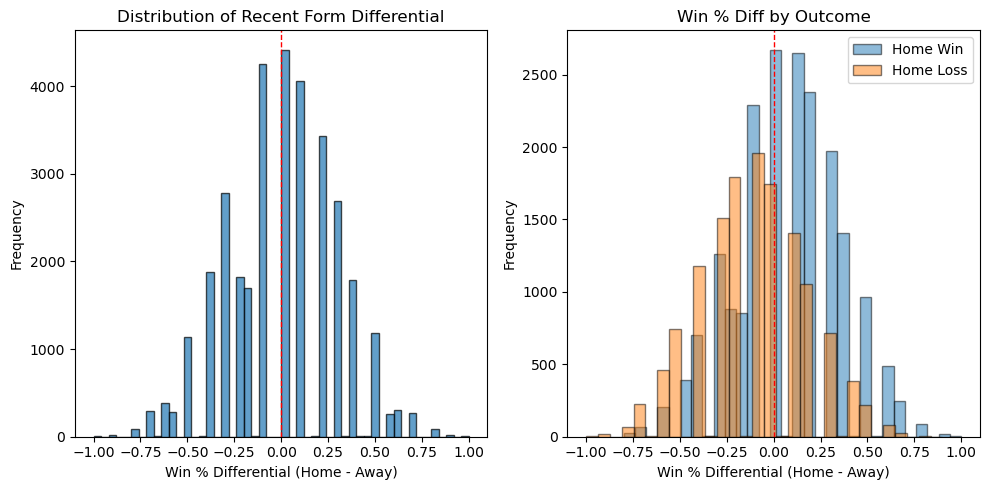

In [69]:
# Distribution of win percentage differential
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(matchups_clean['win_pct_L10_diff'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Win % Differential (Home - Away)')
plt.ylabel('Frequency')
plt.title('Distribution of Recent Form Differential')
plt.axvline(0, color='red', linestyle='--', linewidth=1)

plt.subplot(1, 2, 2)
plt.hist(matchups_clean[matchups_clean['win_home'] == 1]['win_pct_L10_diff'], 
         bins=30, alpha=0.5, label='Home Win', edgecolor='black')
plt.hist(matchups_clean[matchups_clean['win_home'] == 0]['win_pct_L10_diff'], 
         bins=30, alpha=0.5, label='Home Loss', edgecolor='black')
plt.xlabel('Win % Differential (Home - Away)')
plt.ylabel('Frequency')
plt.title('Win % Diff by Outcome')
plt.legend()
plt.axvline(0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


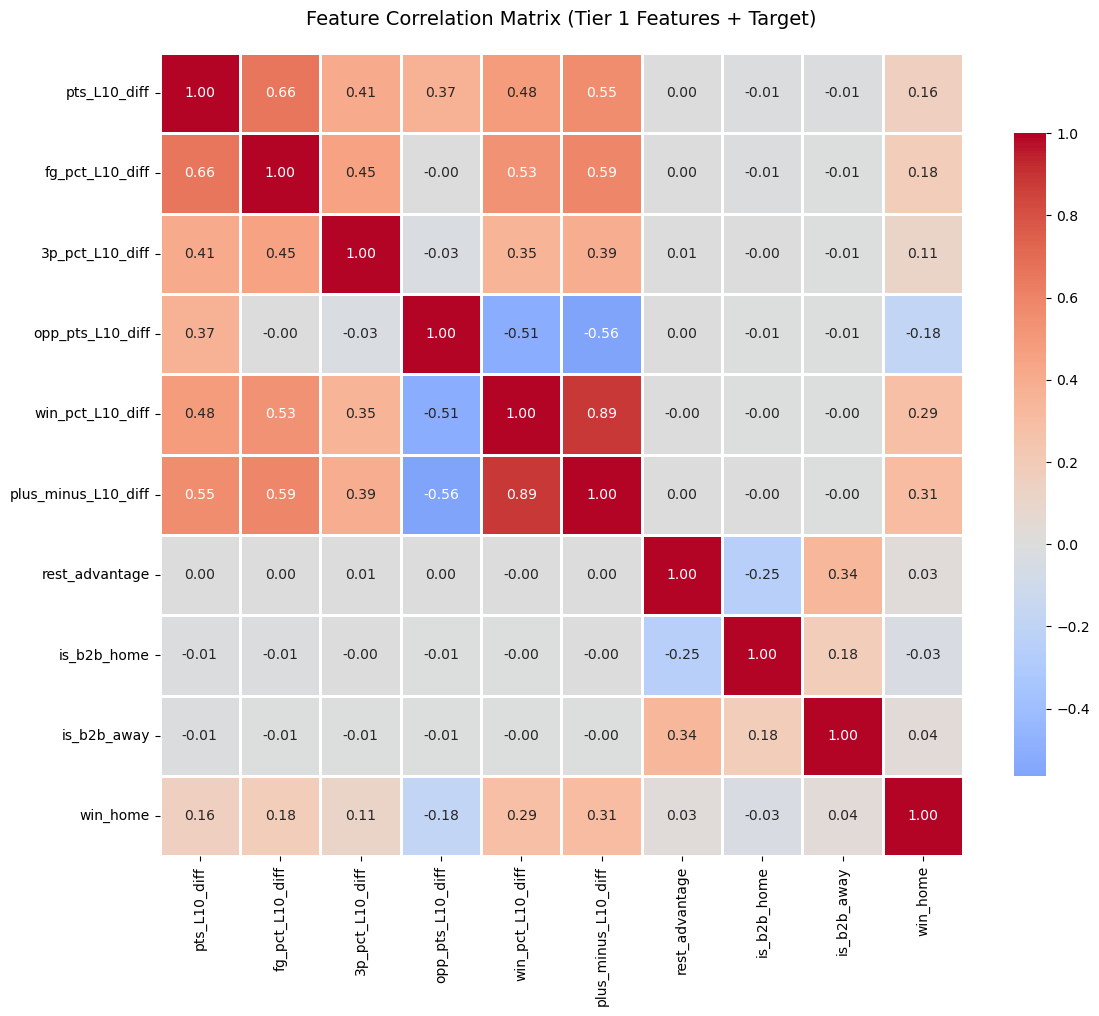


Note: Showing Tier 1 features only for readability.


In [70]:
# Correlation heatmap for Tier 1 features (keep it focused for readability)
plt.figure(figsize=(12, 10))
corr_matrix = matchups_clean[tier1_features + ['win_home']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix (Tier 1 Features + Target)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nNote: Showing Tier 1 features only for readability.")


## 8. Save Processed Data

Save both the individual game data and the matchup dataset.


In [71]:
# Save the processed game data (with rolling features)
games_clean = games.dropna(subset=['pts_L10'])
games_clean.to_csv('nba_games_with_features.csv', index=False)
print(f"✓ Saved: nba_games_with_features.csv ({len(games_clean):,} rows)")

# Save the matchup dataset (ready for modeling)
matchups_clean.to_csv('nba_matchups_with_features.csv', index=False)
print(f"✓ Saved: nba_matchups_with_features.csv ({len(matchups_clean):,} rows)")

print("\n" + "="*70)
print("DATA WRANGLING COMPLETE!")
print("="*70)
print("\nNext steps:")
print("1. Explore the data (EDA)")
print("2. Train models using Tier 1 features")
print("3. Evaluate and iterate")


✓ Saved: nba_games_with_features.csv (70,849 rows)
✓ Saved: nba_matchups_with_features.csv (33,204 rows)

DATA WRANGLING COMPLETE!

Next steps:
1. Explore the data (EDA)
2. Train models using Tier 1 features
3. Evaluate and iterate


---

## Summary

**What we did:**
1. ✓ Loaded game data from `team_traditional.csv`
2. ✓ Calculated rolling features (last 10 games) using point-in-time data (`.shift(1)` to prevent leakage)
3. ✓ Added contextual features (rest days, back-to-backs, win streaks)
4. ✓ Created matchup dataset combining home and away team features
5. ✓ Calculated differentials (home - away) for each feature
6. ✓ Cleaned data (removed early season games with insufficient history)
7. ✓ Saved processed datasets

**Output files:**
- `nba_games_with_features.csv` - Individual game data with rolling features
- `nba_matchups_with_features.csv` - Matchup data ready for modeling

**Tier 1 Features (9 core features):**
1. `pts_L10_diff` - Point differential
2. `fg_pct_L10_diff` - Field goal % differential
3. `3p_pct_L10_diff` - Three-point % differential
4. `opp_pts_L10_diff` - Defensive strength differential
5. `win_pct_L10_diff` - Win % differential
6. `plus_minus_L10_diff` - Point differential (from box score)
7. `rest_advantage` - Rest days differential
8. `is_b2b_home` - Home team on back-to-back
9. `is_b2b_away` - Away team on back-to-back

**Tier 2 Features (10 advanced features):**
1. `efg_pct_L10_diff` - Effective FG% differential
2. `ts_pct_L10_diff` - True shooting % differential
3. `3pa_rate_L10_diff` - 3-point attempt rate differential
4. `ast_L10_diff` - Assists differential
5. `tov_L10_diff` - Turnovers differential
6. `reb_L10_diff` - Rebounds differential
7. `stl_L10_diff` - Steals differential
8. `blk_L10_diff` - Blocks differential
9. `pts_std_L10_diff` - Point volatility differential
10. `win_streak_diff` - Win streak differential

**Total: 19 features for modeling**

**Target variable:** `win_home` (1 = home team wins, 0 = away team wins)


In [72]:
# Quick peek at final dataset structure
print("Final matchup dataset structure:")
print(f"Shape: {matchups_clean.shape}")
print(f"\nSample with Tier 1 features:")
matchups_clean[['date', 'team_home', 'team_away', 'win_home'] + tier1_features[:5]].head(3)


Final matchup dataset structure:
Shape: (33204, 118)

Sample with Tier 1 features:


,date,team_home,team_away,win_home,pts_L10_diff,fg_pct_L10_diff,3p_pct_L10_diff,opp_pts_L10_diff,win_pct_L10_diff
1,1996-11-12,ATL,CLE,1.0,2.000000,-1.963333,3.190000,8.000000,-0.300000
2,1996-11-15,ATL,MIA,1.0,-4.392857,-2.503571,7.317857,-3.571429,-0.214286
3,1996-11-26,ATL,VAN,1.0,-1.200000,-0.870000,0.370000,-8.600000,0.400000


In [73]:
# Season breakdown (for train/test splits)
print("Games per season (for planning train/val/test splits):")
season_counts = matchups_clean.groupby('season').agg({
    'gameid': 'count',
    'win_home': 'mean'
}).round(3)
season_counts.columns = ['# Games', 'Home Win %']
print(season_counts)

print("\n💡 Recommended splits:")
print("   Training: seasons 2015-2021")
print("   Validation: seasons 2022-2023")
print("   Test: season 2024")
print("   Live: season 2025")


Games per season (for planning train/val/test splits):
        # Games  Home Win %
season                     
1997       1183       0.590
1998       1182       0.604
1999        711       0.626
2000       1184       0.617
2001       1182       0.600
2002       1183       0.587
2004       1193       0.622
2005       1233       0.602
2006       1238       0.614
2007       1229       0.594
2008       1236       0.612
2009       1237       0.611
2010       1231       0.598
2011       1230       0.610
2012        993       0.587
2013       1234       0.613
2014       1242       0.572
2015       1232       0.574
2016       1238       0.603
2017       1230       0.582
2018       1232       0.588
2019       1233       0.588
2020       1066       0.545
2021       1091       0.552
2022       1245       0.551
2023       1241       0.580
2024       1237       0.546
2025       1238       0.551

💡 Recommended splits:
   Training: seasons 2015-2021
   Validation: seasons 2022-2023
   Test: season 20

In [74]:
# Show a sample with Tier 2 features as well
print("\nSample with Tier 2 features:")
matchups_clean[['date', 'team_home', 'team_away'] + tier2_features[:5]].head(3)



Sample with Tier 2 features:


,date,team_home,team_away,efg_pct_L10_diff,ts_pct_L10_diff,3pa_rate_L10_diff,ast_L10_diff,tov_L10_diff
1,1996-11-12,ATL,CLE,0.000177,0.015560,0.091464,-3.466667,0.433333
2,1996-11-15,ATL,MIA,-0.004731,0.005198,0.045860,-2.142857,1.321429
3,1996-11-26,ATL,VAN,0.003026,0.008243,0.059544,-5.500000,0.300000
